<a href="https://colab.research.google.com/github/s4kh4rov/BMIL/blob/master/task2_flowers_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install chitra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import cv2
import os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import glob
import pandas as pd
import numpy as np
import chitra
from chitra.image import Chitra
from chitra.dataloader import Clf
from PIL import Image 
import PIL 
import matplotlib.image as mpimg
import keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
from PIL.ImageDraw import Draw

from datetime import datetime


In [12]:
def yolo_to_coco(x_center, y_center, w, h,  image_w, image_h):
    w = w * image_w
    h = h * image_h
    x1 = ((2 * x_center * image_w) - w)/2
    y1 = ((2 * y_center * image_h) - h)/2
    return [x1, y1, w, h]

In [13]:
def show_images(filenames):
  for file in filenames:
    image = mpimg.imread(file)
    plt.figure()
    plt.imshow(image)

In [14]:
def prepare_dataset(path_dir,target_img_h,target_image_w,path_to_save_resized_img):
  # all txt annotations -> csv
  # resize image and save
  # recalculate bbox coordinates
  # split on train, test, validation
  txt_file_list  =  glob.glob(path_dir+'*.txt')
  print("Общее количество txt файлов в директории ", len(txt_file_list))
  result_list = []
  for file in txt_file_list:
      related_image_filename = os.path.splitext(os.path.basename(file))[0]+".jpg"; 
      path_to_related_img = path_dir+related_image_filename;
      image_cv = cv2.imread(path_to_related_img)
      height, width, channels = image_cv.shape
      with open (file, 'r') as f:
          s_text_list = f.readlines()
          for line in s_text_list:
            li = list(line.split(" "))
            if(li[0] == '0'):
              lable = "flower"
              x1, y1, w, h = yolo_to_coco(float(li[1]),float(li[2]),float(li[3]),float(li[4]),width,height)
              bbox_coord = [x1,y1,x1 + w,y1+h]
              image = Chitra(path_to_related_img, bbox_coord, lable)
              image.resize_image_with_bbox((target_img_h, target_image_w))

              value = (related_image_filename,
                       target_image_w,
                       target_img_h,
                       lable,
                       image.bboxes[0].x1,
                       image.bboxes[0].y1,
                       image.bboxes[0].x2,
                       image.bboxes[0].y2)
              result_list.append(value)
      image.image.save(path_to_save_resized_img+related_image_filename)
  column_name = ['filename', 'width', 'height','class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(result_list, columns=column_name)
  return xml_df

In [29]:
path_dir = '/content/drive/MyDrive/flowers/'
path_to_save_resized_img = '/content/drive/MyDrive/flowers_resized/' 
path_to_annotations = '/content/drive/MyDrive/'
target_img_h = 216
target_img_w = 216
dirs = ["test","train","valid"]
num_classes = 2
classes = ["flower", "Noflower"]
# for d in dirs: 
#   print(path_dir+d)
#   xml_df = prepare_dataset(path_dir+d+"/",target_img_h,target_img_w,path_to_save_resized_img+d+"/")
#   xml_df.to_csv(path_to_annotations+d+"_annotations.csv",index=None)

In [52]:
def load_data(path_to_img,path_to_annotations):
  training_image_records = pd.read_csv(path_to_annotations)

  all_images = []
  all_targets = []
  all_labels = []

  for index, row in training_image_records.iterrows():
      
      (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
      
      image_fullpath = os.path.join(path_to_img, filename)
      img = keras.preprocessing.image.load_img(image_fullpath, target_size=(height, width))
      img_arr = keras.preprocessing.image.img_to_array(img)
      
      
      xmin = round(xmin/ width, 2)
      ymin = round(ymin/ height, 2)
      xmax = round(xmax/ width, 2)
      ymax = round(ymax/ height, 2)

      all_images.append(img_arr)
      all_targets.append((xmin, ymin, xmax, ymax))
      all_labels.append(0)
  return (all_images,all_targets,all_labels)

Количество цветков в тренировочной выборке  1346
Количество цветков в тестовой выборке  150
Количество цветков в валидационной выборке  496


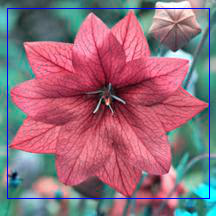

In [54]:
# train_images,train_targets,train_labels = load_data(path_to_save_resized_img+"train/",path_to_annotations+"train_annotations.csv")
# test_images,test_targets,test_labels = load_data(path_to_save_resized_img+"test/",path_to_annotations+"test_annotations.csv")
# valid_images,valid_targets,valid_labels = load_data(path_to_save_resized_img+"valid/",path_to_annotations+"valid_annotations.csv")

# train_images = np.array(train_images)
# train_targets = np.array(train_targets)
# train_labels = np.array(train_labels)

# test_images = np.array(test_images)
# test_targets = np.array(test_targets)
# test_labels = np.array(test_labels)

# valid_images = np.array(valid_images)
# valid_targets = np.array(valid_targets)
# valid_labels = np.array(valid_labels)

print("Количество цветков в тренировочной выборке ",len(train_images))
print("Количество цветков в тестовой выборке ",len(test_images))
print("Количество цветков в валидационной выборке ",len(valid_images))
image= train_images[0]
cv2.rectangle(image,(int(train_targets[0][0]),int(train_targets[0][1])),(int(train_targets[0][2]),int(train_targets[0][3])),(255,0,0),1)
cv2_imshow(image)



In [55]:
input_shape = (target_img_h, target_img_w, 3)
input_layer = tf.keras.layers.Input(input_shape)

#create the base layers
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

#create the classifier branch
classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes, name='cl_head')(classifier_branch) 

#create the localiser branch
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

In [56]:
model = tf.keras.Model(input_layer,
           outputs=[classifier_branch,locator_branch])
losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
          "bb_head":tf.keras.losses.MSE}
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

trainTargets = { 
    "cl_head": train_labels, 
    "bb_head": train_targets 
}
validationTargets = { 
    "cl_head": valid_labels, 
    "bb_head": valid_targets 
}
testTargets = { 
    "cl_head": test_labels, 
    "bb_head": test_targets 
}

history = model.fit (train_images , trainTargets , 
             validation_data=(valid_images , validationTargets), 
             batch_size=4, 
             epochs = 20, 
             shuffle=True, 
             verbose=1)
print('\nhistory dict:', history.history)

results = model.evaluate(test_images, testTargets)
print('test loss, test acc:', results)
now = datetime.now()
date_time = now.strftime("%m-%d-%Y-%H:%M:%S")
model.save("/content/drive/MyDrive/{}-model.h5".format(date_time))



Epoch 1/20
337/337 [==============================] - 140s 412ms/step - loss: 14252.1025 - cl_head_loss: 0.0022 - bb_head_loss: 14252.0996 - cl_head_accuracy: 0.9970 - bb_head_accuracy: 0.0037 - val_loss: 14272.6211 - val_cl_head_loss: 0.0000e+00 - val_bb_head_loss: 14272.6211 - val_cl_head_accuracy: 1.0000 - val_bb_head_accuracy: 0.0000e+00
Epoch 2/20
337/337 [==============================] - 129s 383ms/step - loss: 14251.7266 - cl_head_loss: 0.0000e+00 - bb_head_loss: 14251.7266 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.0000e+00 - val_loss: 14272.6211 - val_cl_head_loss: 0.0000e+00 - val_bb_head_loss: 14272.6211 - val_cl_head_accuracy: 1.0000 - val_bb_head_accuracy: 0.0000e+00
Epoch 3/20
337/337 [==============================] - 122s 363ms/step - loss: 14251.7285 - cl_head_loss: 0.0000e+00 - bb_head_loss: 14251.7285 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.0000e+00 - val_loss: 14272.6211 - val_cl_head_loss: 0.0000e+00 - val_bb_head_loss: 14272.6211 - val_cl_head_accu

In [85]:
model = tf.keras.models.load_model("/content/drive/MyDrive/2022-09:46:23-model.h5")

1/1 [==============================] - 0s 39ms/step
[array([[ 21.69783 , -21.697905]], dtype=float32), array([[0.2594096, 0.2642132, 0.7278003, 0.7592117]], dtype=float32)]
[ 56.032475  57.070053 157.20486  163.98973 ]


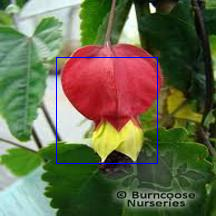

In [89]:
image = cv2.imread("/content/drive/MyDrive/test/1.jpg")
img_arr_p = tf.reshape(image, (-1, target_img_h, target_img_w, 3))
result = model.predict(img_arr_p)
print(result)
bbox=result[1][0]*target_img_h
print(bbox)
cv2.rectangle(image,(int(bbox[0]),int(bbox[1])),(int(bbox[2]),int(bbox[3])),(255,0,0),1)
cv2_imshow(image)